## Performance Evaluation

The learning objectives are to
- Learn to generate ROC and AUC for performance evaluation of algorithms;
- Employ cross validations for model tuning and comparison;
- Conduct statistical significance tests on performance data.

### Data preparation

First, we import some utilities that allow us to retrieve some UCI datasets via a URL: 

In [1]:
# import Pkg; Pkg.add("UrlDownload")

In [2]:
using UrlDownload

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data";
feature_names = ["ID", "Class", "mean radius", "mean texture", "mean perimeter", "mean area", "mean smoothness", "mean compactness", "mean concavity", "mean concave points", "mean symmetry", "mean fractal dimension", "radius error", "texture error", "perimeter error", "area error", "smoothness error", "compactness error", "concavity error", "concave points error", "symmetry error", "fractal dimension error", "worst radius", "worst texture", "worst perimeter", "worst area", "worst smoothness", "worst compactness", "worst concavity", "worst concave points", "worst symmetry", "worst fractal dimension"]
data = urldownload(url, true, format = :CSV, header = feature_names);

We can now turn the downloaded CSV instance into a DataFrame: 

In [4]:
using DataFrames
df = DataFrame(data)[:, 2:end];

... and we can use MLJ to extract the X and y, and do a random partition of training and testing instances: 

In [5]:
using MLJ
coerce!(df, :Class => OrderedFactor{2})
y, X = unpack(df, ==(:Class),name->true);

In [6]:
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=13);

### ROC and AUC

Let's use a simple kNN classifier and obtain some performance metrics. 

In [7]:
using NearestNeighborModels 

In [8]:
clf = machine(KNNClassifier(K=5), X, y)
fit!(clf, rows=train)
y_pred= MLJ.predict(clf, rows=test)

[ Info: Training machine(KNNClassifier(K = 5, …), …).


114-element CategoricalDistributions.UnivariateFiniteVector{OrderedFactor{2}, InlineStrings.String1, UInt32, Float64}:
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.4, M=>0.6)
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=>0.0)
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=>0.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=>0.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.8, M=>0.2)
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=>0.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.0, M=>1.0)
 ⋮
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=>0.0)
 UnivariateFinite{OrderedFactor{2}}(B=>0.8, M=>0.2)
 UnivariateFinite{OrderedFactor{2}}(B=>0.6, M=>0.4)
 UnivariateFinite{OrderedFactor{2}}(B=>1.0, M=

We can calculate the accuracy comparing the predicted "mode" and groundtruth (y[test]):

In [9]:
accuracy(mode.(y_pred), y[test])

0.9035087719298246

As "y_pred" gives us probabilistic prediction, we can use it for ROC curve generation: 

In [10]:
using Plots

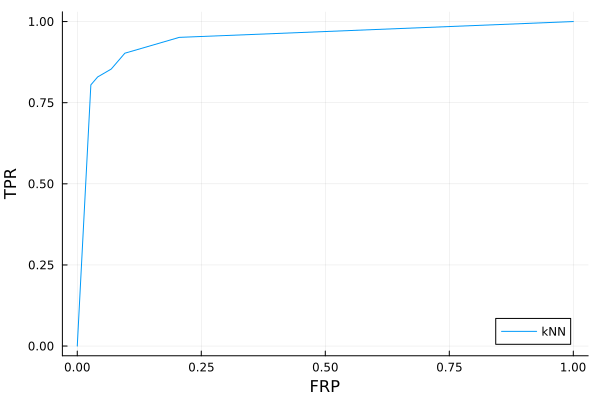

In [11]:
#Plotting the ROC-AUC curve for each model being iterated
fprs, tprs, thresholds = roc(y_pred, y[test])
Plots.plot(fprs, tprs, label="kNN", xlabel="FRP", ylabel="TPR")

MLJ provides a function for calculating AUC (area under the ROC curve) 

In [12]:
auc_roc = auc(y_pred, y[test])

0.9460407617774808

### Let's do it properly

If we take a look of our data again, we may notice something of concern: 

In [13]:
describe(X)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,mean radius,14.1273,6.981,13.37,28.11,0,Float64
2,mean texture,19.2896,9.71,18.84,39.28,0,Float64
3,mean perimeter,91.969,43.79,86.24,188.5,0,Float64
4,mean area,654.889,143.5,551.1,2501.0,0,Float64
5,mean smoothness,0.0963603,0.05263,0.09587,0.1634,0,Float64
6,mean compactness,0.104341,0.01938,0.09263,0.3454,0,Float64
7,mean concavity,0.0887993,0.0,0.06154,0.4268,0,Float64
8,mean concave points,0.0489191,0.0,0.0335,0.2012,0,Float64
9,mean symmetry,0.181162,0.106,0.1792,0.304,0,Float64


Obviously the ranges of the attribute values differ a lot! 

**Task 1**. Use MLJ's Standardizer to standardize the X data. Re-train your model and regenerate the ROC curve and performance metrics. 

Accuarcy=0.982	AUC=0.997

[ Info: Training machine(Standardizer(features = Symbol[], …), …).
[ Info: Training machine(KNNClassifier(K = 5, …), …).


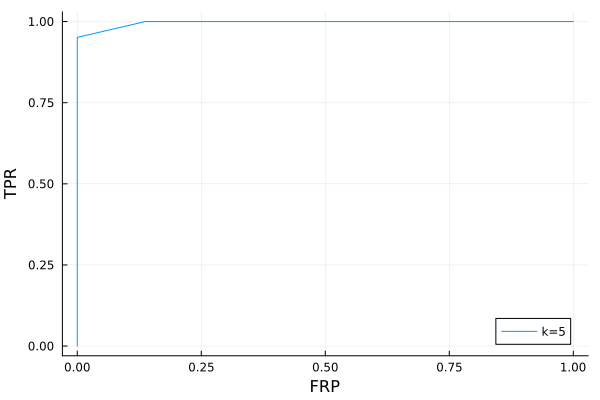

In [14]:
# code for Test 1
using Printf, Plots
transformer_instance = Standardizer()
transformer_model = machine(transformer_instance, X)
fit!(transformer_model)
X = MLJ.transform(transformer_model, X);

clf = machine(KNNClassifier(K=5), X, y)
fit!(clf, rows=train)
y_pred= MLJ.predict(clf, rows=test)
@printf "Accuarcy=%4.3f\tAUC=%4.3f" accuracy(mode.(y_pred), y[test]) auc(y_pred, y[test])
fprs, tprs, thresholds = roc(y_pred, y[test])
plot(fprs, tprs, label="k=5", xlabel="FRP", ylabel="TPR")

**Task 2.** Change k to 23 and redo training and testing; regenerate ROC and AUC for comparison. 

Accuarcy=0.956	AUC=0.993

[ Info: Training machine(KNNClassifier(K = 23, …), …).


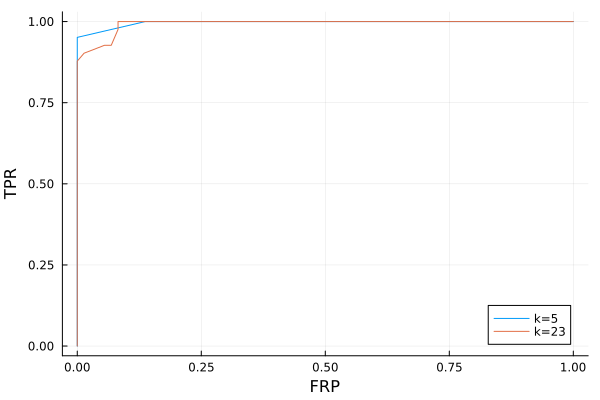

In [15]:
# code for Task 2
clf = machine(KNNClassifier(K=23), X, y)
fit!(clf, rows=train)
y_pred= MLJ.predict(clf, rows=test)
@printf "Accuarcy=%4.3f\tAUC=%4.3f" accuracy(mode.(y_pred), y[test]) auc(y_pred, y[test])
fprs, tprs, thresholds = roc(y_pred, y[test])
plot!(fprs, tprs, label="k=23", xlabel="FRP", ylabel="TPR")

### Cross validations

MLJ provides some handy performance evaluation tools. Here, we use "evaluate()" to evaluate a model (note: not a machine as the model will build a different machine for each fold) on a dataset, given a resampling method and a performance measure: 

In [16]:
cv=CV(nfolds=10)
knn = KNNClassifier(K=23)
perf = evaluate(knn, X, y, resampling=cv, measure=auc, verbosity=0)

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌──────────────────┬───────────┬─────────────┬─────────┬────────────────────────
│ measure          │ operation │ measurement │ 1.96*SE │ per_fold              ⋯
├──────────────────┼───────────┼─────────────┼─────────┼────────────────────────
│ AreaUnderCurve() │ predict   │ 0.99        │ 0.00954 │ [0.996, 0.986, 0.99,  ⋯
└──────────────────┴───────────┴─────────────┴─────────┴────────────────────────
                                                                1 column omitted


We can check out the per-fold performance measure: 

In [17]:
perf.per_fold

1-element Vector{Vector{Float64}}:
 [0.9960474308300395, 0.9857142857142858, 0.9900793650793651, 0.9981527093596059, 0.9895320197044335, 0.95, 1.0, 0.9947552447552448, 0.9982517482517482, 0.9928443649373881]

Now we can display the performance data using a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) (an improved version of the box plot): 

In [18]:
# import Pkg; Pkg.add("StatsPlots")

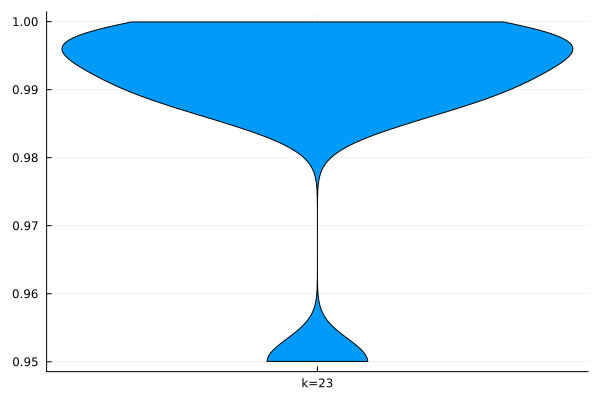

In [19]:
using StatsPlots
violin(["k=23"], perf.per_fold, label=nothing)

In [20]:
knn = KNNClassifier(K=1)
perf = evaluate(knn, X, y, resampling=cv, measure=auc, verbosity=0)

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌──────────────────┬───────────┬─────────────┬─────────┬────────────────────────
│ measure          │ operation │ measurement │ 1.96*SE │ per_fold              ⋯
├──────────────────┼───────────┼─────────────┼─────────┼────────────────────────
│ AreaUnderCurve() │ predict   │ 0.946       │ 0.0166  │ [0.967, 0.934, 0.962, ⋯
└──────────────────┴───────────┴─────────────┴─────────┴────────────────────────
                                                                1 column omitted


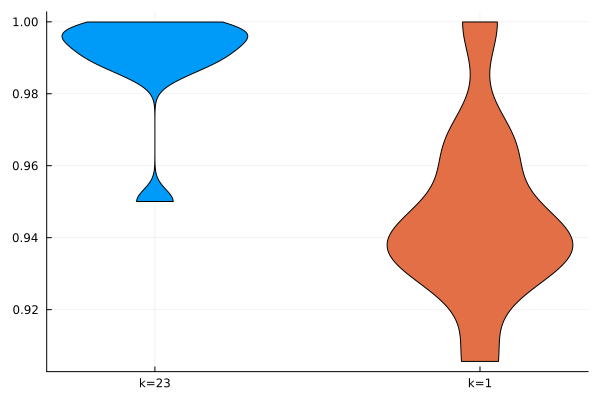

In [21]:
violin!(["k=1"], perf.per_fold, label=nothing)

**Task 3**. Run the 10-fold CV for 20 times and regenerate the violin plots. 

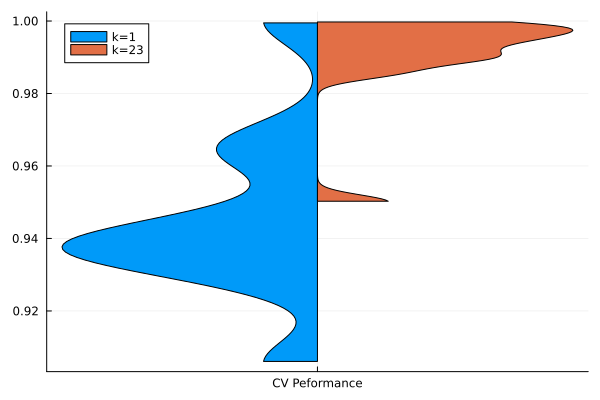

In [22]:
# code for Task 3
perf1 = []
perf2 = []
for t =1:20
    cv=CV(nfolds=10)
    knn = KNNClassifier(K=1)
    perf = evaluate(knn, X, y, resampling=cv, measure=auc, verbosity=0)
    perf1 = vcat(perf1, perf.per_fold[1])
    knn = KNNClassifier(K=23)
    perf = evaluate(knn, X, y, resampling=cv, measure=auc, verbosity=0)
    perf2 = vcat(perf2, perf.per_fold[1])
end
#violin(["k=1"],perf1, label=nothing)
#violin!(["k=23"],perf2, label=nothing)
violin(["CV Peformance"], perf1, label="k=1", side=:left)
violin!(["CV Peformance"], perf2, label="k=23", side=:right)

### Statistical significance

Suppose we have two samples collected under comparable conditions; e.g., scores from two teams in a tournament:

In [23]:
t1 = [18, 21, 16, 22, 19, 24, 17, 21, 23, 18, 14, 16, 16, 19, 18, 20, 12, 22, 15, 17]
t2 = [22, 25, 17, 24, 16, 29, 20, 23, 19, 20, 15, 15, 18, 26, 18, 24, 18, 25, 19, 16];

The violin plot below tells some story: 

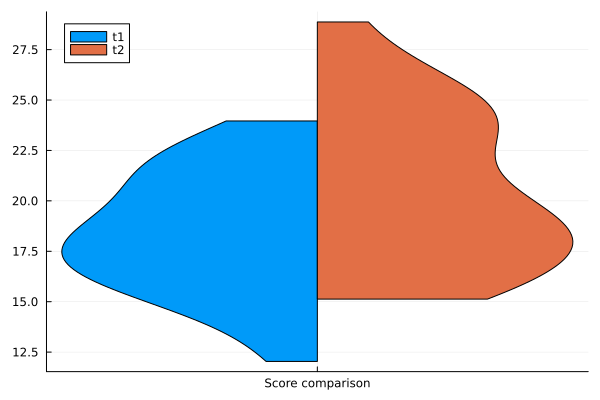

In [24]:
violin(["Score comparison"], t1, side=:left, label="t1")
violin!(["Score comparison"], t2, side=:right, label="t2")

We check up the mean and stdev of both arrays - they are a bit different: 

In [25]:
mean(t1),std(t1)

(18.4, 3.1522757026096495)

In [26]:
mean(t2), std(t2)

(20.45, 4.058454463410788)

Can we be sure that the difference between the two teams' average scores is statistically significant? We need to employ some statistical tests: 

In [27]:
# import Pkg; Pkg.add("HypothesisTests")
using HypothesisTests

In [28]:
UnequalVarianceTTest(t1, t2) # paired t-test

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -2.05
    95% confidence interval: (-4.381, 0.2809)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0829

Details:
    number of observations:   [20,20]
    t-statistic:              -1.7840292427015183
    degrees of freedom:       35.807723175100485
    empirical standard error: 1.1490843036270686


Or, a non-parametric test: 

In [29]:
MannWhitneyUTest(t1, t2)  # another test: on whether t1 is consistently better/worse than t2

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -1.5

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1388

Details:
    number of observations in each group: [20, 20]
    Mann-Whitney-U statistic:             145.0
    rank sums:                            [355.0, 465.0]
    adjustment for ties:                  528.0
    normal approximation (μ, σ):          (-55.0, 36.8155)


As seen, both tests return the same "fail to reject h_0" outcome. In short, the p-value (greater than 0.05) indicates that there is at least 95% confidence that both teams' scores are statistically identical! 

**Task 4**. Carry out a statistical significance test on the 10-fold CV performance data obtained from Task 3. Is "k=1" worse than "k=23"? 

In [30]:
# Task 4
pvalue(MannWhitneyUTest(convert(Array{Float64,1}, perf1), convert(Array{Float64,1}, perf2)))

1.2431816825905865e-40